# Regresión Logística
#### UD2. Aprendizaxe Supervisada
#### MP. Sistemas de Aprendizaxe Automáticos
#### IES de Teis (Vigo), Cristina Gómez Alonso

En este notebook tomaremos como referencia el material del profesor Dr. Tirthajyoti Sarkar donde demuestra como resolver un problema de regresión logística de predicción de Hipotiroidismo con las librerías **Scikit-learn** y **Statsmodels**.

El dataset es original de UCI ML repository.
<br>Link: https://archive.ics.uci.edu/ml/datasets/Thyroid+

Explicaciones previas:
* [Glándula tiroides](https://es.wikipedia.org/wiki/Gl%C3%A1ndula_tiroides)
* [Hipotiroidismo](https://www.youtube.com/watch?v=RYGjvqrj22Q) minuto 1:53

## 1. Importación de paquetes y dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
names = 'response age sex on_thyroxine query_on_thyroxine antithyroid_medication thyroid_surgery query_hypothyroid query_hyperthyroid pregnant \
sick tumor lithium goitre TSH_measured TSH T3_measured \
T3 TT4_measured TT4 T4U_measured T4U FTI_measured FTI TBG_measured TBG'

In [3]:
names = names.split(' ')

In [4]:
df = pd.read_csv('data/hypothyroid.csv',index_col=False,names=names,na_values=['?'])

In [5]:
df.head()

,response,age,sex,on_thyroxine,query_on_thyroxine,antithyroid_medication,thyroid_surgery,query_hypothyroid,query_hyperthyroid,pregnant,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG
0,hypothyroid,72.0,M,f,f,f,f,f,f,f,...,y,0.6,y,15.0,y,1.48,y,10.0,n,NaN
1,hypothyroid,15.0,F,t,f,f,f,f,f,f,...,y,1.7,y,19.0,y,1.13,y,17.0,n,NaN
2,hypothyroid,24.0,M,f,f,f,f,f,f,f,...,y,0.2,y,4.0,y,1.00,y,0.0,n,NaN
3,hypothyroid,24.0,F,f,f,f,f,f,f,f,...,y,0.4,y,6.0,y,1.04,y,6.0,n,NaN
4,hypothyroid,77.0,M,f,f,f,f,f,f,f,...,y,1.2,y,57.0,y,1.28,y,44.0,n,NaN


In [6]:
df.shape

(3163, 26)

## 2. Preprocessing

### 2.1. Borrado de columnas innecesarias

Borraremos todas las features que tienen en su nombre la palabra measured o querey ya que son redundantes.

In [7]:
to_drop=[]
for c in df.columns:
    if 'measured' in c or 'query' in c:
        to_drop.append(c)

In [8]:
to_drop

['query_on_thyroxine',
 'query_hypothyroid',
 'query_hyperthyroid',
 'TSH_measured',
 'T3_measured',
 'TT4_measured',
 'T4U_measured',
 'FTI_measured',
 'TBG_measured']

In [9]:
to_drop.append('TBG')

In [10]:
df.drop(to_drop,axis=1,inplace=True)

In [11]:
df.head()

,response,age,sex,on_thyroxine,antithyroid_medication,thyroid_surgery,pregnant,sick,tumor,lithium,goitre,TSH,T3,TT4,T4U,FTI
0,hypothyroid,72.0,M,f,f,f,f,f,f,f,f,30.0,0.6,15.0,1.48,10.0
1,hypothyroid,15.0,F,t,f,f,f,f,f,f,f,145.0,1.7,19.0,1.13,17.0
2,hypothyroid,24.0,M,f,f,f,f,f,f,f,f,0.0,0.2,4.0,1.00,0.0
3,hypothyroid,24.0,F,f,f,f,f,f,f,f,f,430.0,0.4,6.0,1.04,6.0
4,hypothyroid,77.0,M,f,f,f,f,f,f,f,f,7.3,1.2,57.0,1.28,44.0


Consultamos los valores estadísticos básicos de cada columna. Si añadimos .T a la función 'describe' podemos transponer la matriz resultado y ayuda a la comprensión de dichos valores.

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2717.0,51.154214,19.294405,1.0,35.00,54.00,67.000,98.00
TSH,2695.0,5.923180,23.899467,0.0,0.00,0.70,2.300,530.00
T3,2468.0,1.939749,0.996773,0.0,1.40,1.80,2.300,10.20
TT4,2914.0,108.850000,45.485419,2.0,83.00,104.00,128.000,450.00
T4U,2915.0,0.978199,0.226580,0.0,0.85,0.96,1.065,2.21
FTI,2916.0,115.397771,60.239572,0.0,91.00,107.00,129.000,881.00


### 2.2. Tratamiento de missing values
La función `df.isna()` retorna un dataframe de valores booleanos (true para indicar la existencia de valor y false para valores missing). Si añadimos la función sum se verán y calcularán el número de missing values para cada columna.

In [13]:
df.isna().sum()

response                    0
age                       446
sex                        73
on_thyroxine                0
antithyroid_medication      0
thyroid_surgery             0
pregnant                    0
sick                        0
tumor                       0
lithium                     0
goitre                      0
TSH                       468
T3                        695
TT4                       249
T4U                       248
FTI                       247
dtype: int64

En este caso borraremos las filas con valores missing ya que desconocemos de conocimiento experto en el área que nos ayude a estimar correctamente dichos valores desconocidos.

In [14]:
df.dropna(inplace=True)

In [15]:
df.shape
df['response'].unique()

array(['hypothyroid', 'negative'], dtype=object)

### 2.3. Transformación de datos categóricos manualmente

La columna **response** contiene los valores 'hypothyroid' para indicar que el paciente sufre hipertiroidismo y 'negative' para indicar que no. Los sustituiremos manualmente por valores numéricos (hypothyroid=1 y negative=0).

In [16]:
def class_convert(response):
    if response=='hypothyroid':
        return 1
    else:
        return 0

In [17]:
df['response']=df['response'].apply(class_convert)

In [18]:
df.head()

,response,age,sex,on_thyroxine,antithyroid_medication,thyroid_surgery,pregnant,sick,tumor,lithium,goitre,TSH,T3,TT4,T4U,FTI
0,1,72.0,M,f,f,f,f,f,f,f,f,30.0,0.6,15.0,1.48,10.0
1,1,15.0,F,t,f,f,f,f,f,f,f,145.0,1.7,19.0,1.13,17.0
2,1,24.0,M,f,f,f,f,f,f,f,f,0.0,0.2,4.0,1.00,0.0
3,1,24.0,F,f,f,f,f,f,f,f,f,430.0,0.4,6.0,1.04,6.0
4,1,77.0,M,f,f,f,f,f,f,f,f,7.3,1.2,57.0,1.28,44.0


In [19]:
df.columns

Index(['response', 'age', 'sex', 'on_thyroxine', 'antithyroid_medication',
       'thyroid_surgery', 'pregnant', 'sick', 'tumor', 'lithium', 'goitre',
       'TSH', 'T3', 'TT4', 'T4U', 'FTI'],
      dtype='object')

## 3. Visual EDA

### 3.1. Diagrama de cajas

Un diagrama de caja (en inglés boxplot) es un método estandarizado para representar gráficamente una serie de datos numéricos a través de sus cuartiles. De esta manera, se muestran a simple vista la mediana(el valor que ocupa la posición central de un conjunto de observaciones ordenadas) y los cuartiles de los datos, y también pueden representarse sus valores atípicos (o outlayers).
![Explicacion boxplot](./data/box_plot.png) 

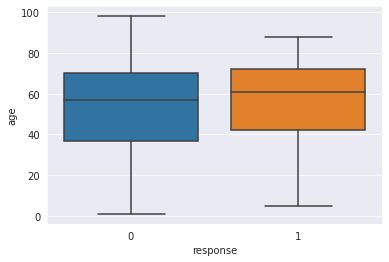

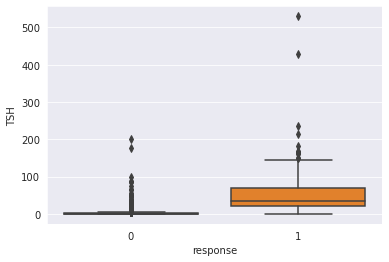

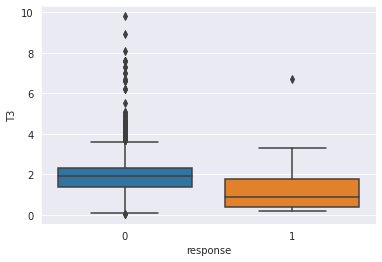

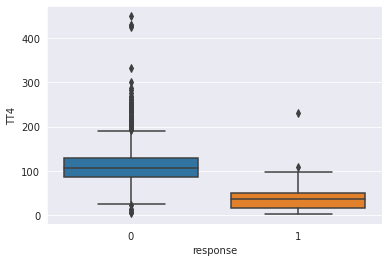

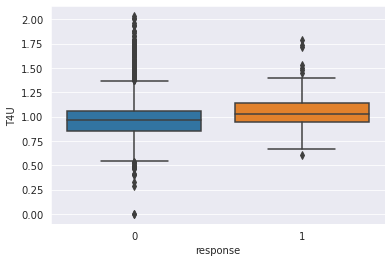

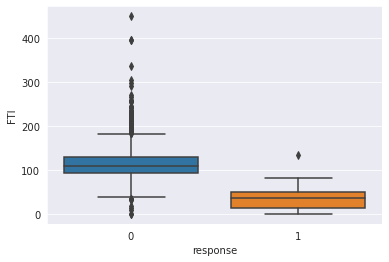

In [20]:
for var in ['age','TSH','T3','TT4','T4U','FTI']:
    sns.boxplot(x='response',y=var,data=df)
    plt.show()

### 3.2. Análisis de correlaciones entre variables independendientes

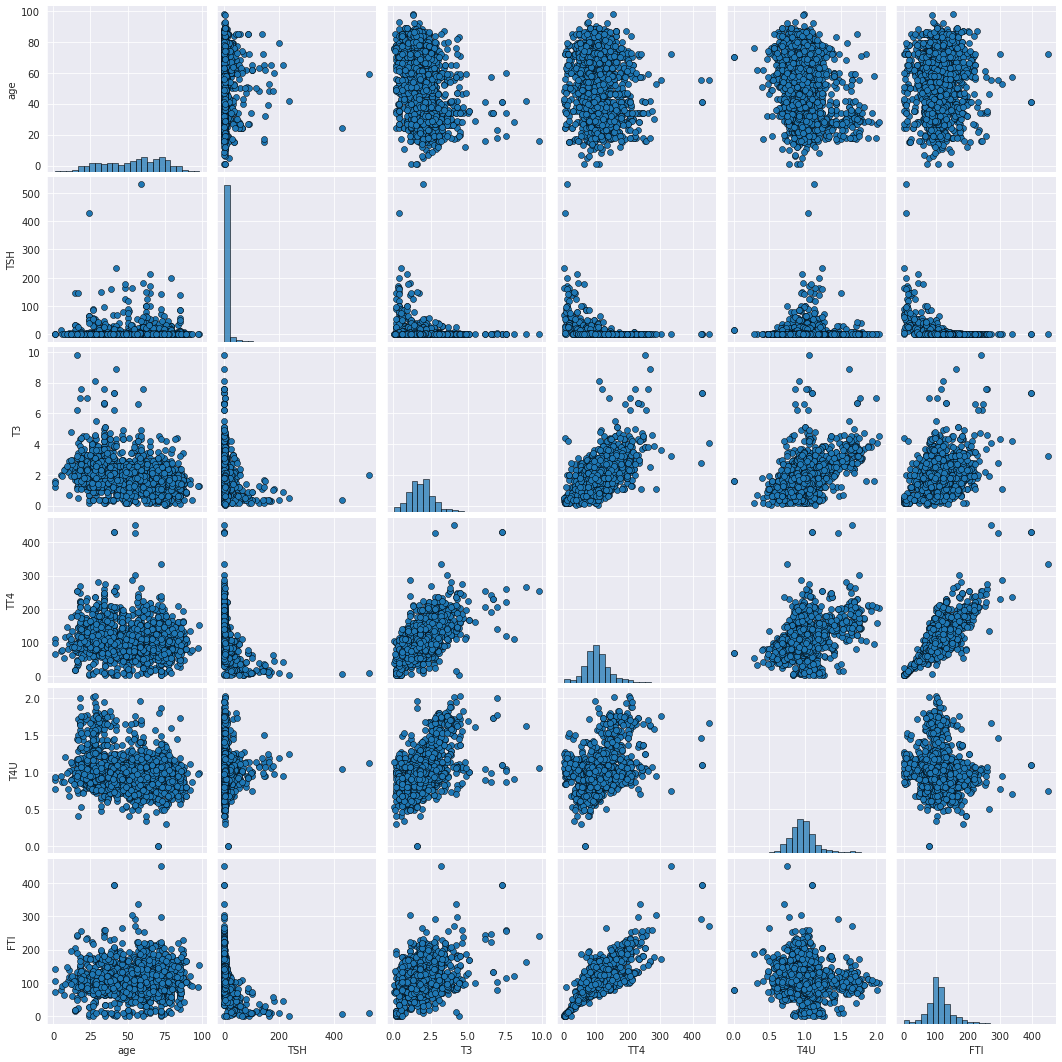

In [21]:
sns.pairplot(data=df[df.columns[1:]],diag_kws={'edgecolor':'k','bins':25},plot_kws={'edgecolor':'k'})
plt.show()

### 3.3. Transformación de datos categóricos con get_dummies

In [22]:
df_dummies = pd.get_dummies(data=df)

In [23]:
df_dummies.shape

(2000, 25)

In [24]:
df_dummies.sample(10)

,response,age,TSH,T3,TT4,T4U,FTI,sex_F,sex_M,on_thyroxine_f,...,pregnant_f,pregnant_t,sick_f,sick_t,tumor_f,tumor_t,lithium_f,lithium_t,goitre_f,goitre_t
80,1,5.0,17.0,2.0,74.0,0.95,78.0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
490,0,42.0,0.0,2.5,112.0,1.04,108.0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
1944,0,41.0,1.8,2.3,84.0,0.95,88.0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
2469,0,34.0,1.2,2.0,83.0,1.00,83.0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
94,1,51.0,82.0,0.6,10.0,0.94,10.0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
2843,0,29.0,2.8,2.2,120.0,0.97,123.0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
901,0,73.0,0.0,1.7,123.0,1.00,123.0,0,1,1,...,1,0,1,0,1,0,1,0,1,0
1327,0,53.0,8.5,1.7,93.0,0.91,102.0,0,1,1,...,1,0,1,0,1,0,1,0,1,0
2666,0,37.0,1.3,2.2,88.0,0.77,114.0,0,1,1,...,1,0,1,0,1,0,1,0,1,0
2818,0,71.0,1.0,1.0,62.0,0.97,64.0,1,0,1,...,1,0,1,0,1,0,1,0,1,0


## 4. División del dataset

La variable X contendrá todas las columnas a excepción de response.
La variable y contendrá exclusivamente la columna response.

In [25]:
from sklearn.model_selection import train_test_split
X = df_dummies.drop('response',axis=1)
y = df_dummies['response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [26]:
print("Training set shape",X_train.shape)
print("Test set shape",X_test.shape)

Training set shape (1400, 24)
Test set shape (600, 24)


## 5. Creación del modelo de Regresión Logística

Se implementará la regresión logística con regularización Ridge L2(por defecto). [Aquí](https://www.iartificial.net/regularizacion-lasso-l1-ridge-l2-y-elasticnet/) más información sobre los tipos de regularizaciones.

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
clf1 = LogisticRegression(penalty='l2')

## 6. Entrenamiento

In [39]:
clf1.fit(X_train,y_train)

/home/a22mariobs/anaconda3/envs/ml_env_linux/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## 7. Cálculo de intercept, coefficients y score

In [30]:
clf1.intercept_

array([0.46158006])

In [31]:
clf1.coef_

array([[ 0.02173403,  0.0194417 , -0.30031819,  0.00271232,  0.44403652,
        -0.10446664,  0.44236045, -0.19797555,  1.04162053, -0.79723563,
         0.77723792, -0.53285302, -0.54789206,  0.79227696,  0.31934056,
        -0.07495566,  0.41443339, -0.17004849,  0.41687152, -0.17248662,
         0.2950971 , -0.0507122 , -0.08694965,  0.33133455]])

In [32]:
clf1.score(X_test,y_test)

0.9816666666666667

## 8. Predicciones

Para las regresiones logísticas, el método `predict_proba` estima la probabilidad de ser de tipo 0 (NO) y la probabilidad de ser de tipo 1(YES).

In [33]:
prob_threshold = 0.5

In [34]:
prob_df=pd.DataFrame(clf1.predict_proba(X_test[:10]),columns=['Prob of NO','Prob of YES'])
prob_df['Decision']=(prob_df['Prob of YES']>prob_threshold).apply(int)
prob_df

,Prob of NO,Prob of YES,Decision
0,0.991011,0.008989,0
1,0.998549,0.001451,0
2,0.999999,0.000001,0
3,0.600792,0.399208,0
4,0.999237,0.000763,0
5,0.857737,0.142263,0
6,0.982374,0.017626,0
7,0.998458,0.001542,0
8,0.241912,0.758088,1
9,0.999964,0.000036,0


In [35]:
y_test[:10]

2944    0
511     0
2116    0
1412    0
2039    0
2013    0
1478    0
2744    0
83      1
2100    0
Name: response, dtype: int64

## 9. Informe de classificación (classification report) y matriz de confusión (confusion matrix)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
print(confusion_matrix(y_test, clf1.predict(X_test)))

[[565   4]
 [  7  24]]


In [38]:
print(classification_report(y_test, clf1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       569
           1       0.86      0.77      0.81        31

    accuracy                           0.98       600
   macro avg       0.92      0.88      0.90       600
weighted avg       0.98      0.98      0.98       600



## Ejercicio: Titanic

1. Carga: toma como base el fichero titanic_train.csv y cárgalo.
2. Visual EDA:
   ¿Exiset algún patrón de supervivencia basado en el sexo?
   Crea el siguiente gráfico: sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')
    ¿Y basado en el clase de los pasajeros (pclass)?
    Crea un histograma que represente la edad de los pasajeros.
    Contrasta la clase respecto a la edad.
3. Preprocessing:
    Sustituye los missing values de la edad por el valor medio.
    Suprime columnas innecesarias.
    Convierte columnas categóricas por variables dummies
4. Creación modelo de regresión logística
5. Entrenamiento
6. Obtén el informe de clasificación y la matriz de confusión.



## Importamos y cargamos ambos datasets CSV

In [30]:
import pandas as pd
df_titanic_train = pd.read_csv("data/titanic_train.csv", sep = ",")
df_titanic_test = pd.read_csv("data/titanic_test.csv", sep = ",")
df_titanic_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [31]:
df_titanic_train.drop(["Cabin"],axis =1,inplace=True)
df_titanic_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
dtype: int64